In [81]:
%matplotlib inline

import os
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage
import scipy.stats
from pprint import pprint
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = [15, 11]

In [2]:
def load_images(path, name):
    """
        Loads original, thermal and visible image from dataset
    """
    original = cv2.imread(os.path.join(path, name)) / 255
    thermal = cv2.imread(os.path.join(path, "extracted/thermal", name)) / 255
    visible = cv2.imread(os.path.join(path, "extracted/visible", name)) / 255
    return original, thermal, visible

def load_prepare(path, name):
    """
        Loads images, scales VIS and FIR to shape and collapses to 1 channel
    """
    orig, thr, vis = load_images(path, name)
    
    # Compress into single channel
    thr = np.mean(thr, 2)
    vis = np.mean(vis, 2)

    # Align shapes
    vis = cv2.resize(vis, (thr.shape[1], thr.shape[0]))
    return orig, thr, vis

def superimpose(a, b):
    """
        Superimposes 2 images
    """
    return np.mean(np.dstack([a, b]), axis=2)

def show(img, ax, title, neg=True):
    """
        Displays an image.
        Uses negative by default for better visibility.
    """
    ax.imshow(1-img if neg else img)
    ax.set_title(title)
    ax.axis("off")

In [3]:
root_path = "../../data/calibration"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)
    
scaling_factor = metadata["shape"]["vis"][0] / metadata["shape"]["thr"][0]
pprint(metadata)

{'candle_distances': {'left_middle': 415, 'middle_right': 380},
 'photos': {'flir_20191112T174218.jpg': {'adjusted': False,
                                         'distance': 1150,
                                         'points': {'thr': [[122, 202],
                                                            [322, 187],
                                                            [513, 187]],
                                                    'vis': [[362, 441],
                                                            [742, 424],
                                                            [1094, 422]]}},
            'flir_20191112T174252.jpg': {'adjusted': False,
                                         'distance': 1950,
                                         'points': {'thr': [[225, 218],
                                                            [346, 206],
                                                            [458, 207]],
                                            

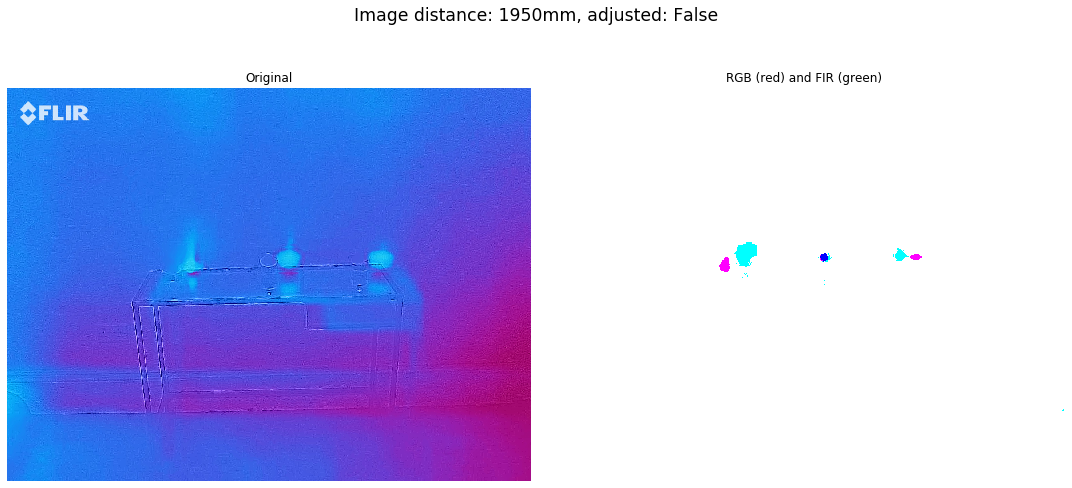

In [50]:
def display_images(path, name, metadata):
    orig, thr, vis = load_prepare(path, name)

    # Threshold
    vis = np.where(vis > 0.91, 1, 0)
    thr = np.where(thr > 0.15, 1, 0)

    # Overlay as red and green channel and plot
    ovr = np.dstack([vis, thr, np.zeros(thr.shape)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    show(orig, ax1, "Original", neg=False)
    show(ovr, ax2, "RGB (red) and FIR (green)")
    
    distance = metadata["photos"][name]["distance"]
    adjusted = metadata["photos"][name]["adjusted"]
    fig.suptitle(f"Image distance: {distance}mm, adjusted: {adjusted}", y=0.85, size="xx-large")
    plt.tight_layout()


display_images(root_path, list(metadata["photos"].keys())[1], metadata)

## NTG

1. Normalize images to [0, 1]
1. Subtract images for difference
1. (plot gradient distributions)

$NTG(f, f_R) = \frac{\sum_l |\nabla_l \{f - f_R\}|}{\sum_l | \nabla_l f | + \sum_l | \nabla_l f_R|}$ with $l \in \{x, y\}$

In [51]:
orig, fir, rgb = load_prepare(root_path, list(metadata["photos"].keys())[1])

In [115]:
def plot_gradients(imgs, names):
    
    distributions = []
    x_scales = []
    
    # x and y gradient kernel
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])

    # Get gradients
    for img in imgs:
        x_gradient = ndimage.convolve(img, kx)
        y_gradient = ndimage.convolve(img, ky)
        total_samples = img.shape[0] * img.shape[1] * 2

        combined_gradient, x_scale = np.histogram(np.array([x_gradient, y_gradient]).flatten(), bins=50)
        combined_gradient = combined_gradient / total_samples
        distributions.append(combined_gradient)
        x_scales.append(x_scale[:-1])
    
    fig, ax = plt.subplots(1)
    ax.set_yscale('log')
    for distribution, x_scale, name in zip(distributions, x_scales, names):
        ax.plot(x_scale, distribution, label=name)
    ax.legend()
    
def total_gradient(f, norm=1):
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])
    
    dx = ndimage.convolve(f, kx)
    dy = ndimage.convolve(f, ky)
    
    return np.linalg.norm(dx, norm) + np.linalg.norm(dy, norm)

def ntg(f, f_ref):
    return total_gradient(f - f_ref) / (total_gradient(f) + total_gradient(f_ref))
    
ntg(rgb, fir) 

0.7131335269359207

In [38]:
X, y = [], []
for name, image in metadata["photos"].items():
    try:
        X.append(metadata["photos"][name]["points"]["vis"])
        y.append(metadata["photos"][name]["points"]["thr"])
    except:
        pass
    
X = np.vstack(X) // scaling_factor
y = np.vstack(y)

model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
transformation = np.hstack([model.coef_, model.intercept_[:, None]])
rgb_trans = cv2.warpAffine(rgb, transformation, (fir.shape[1], fir.shape[0]))

In [46]:
ntg(rgb_trans, fir)

0.6967777734165032

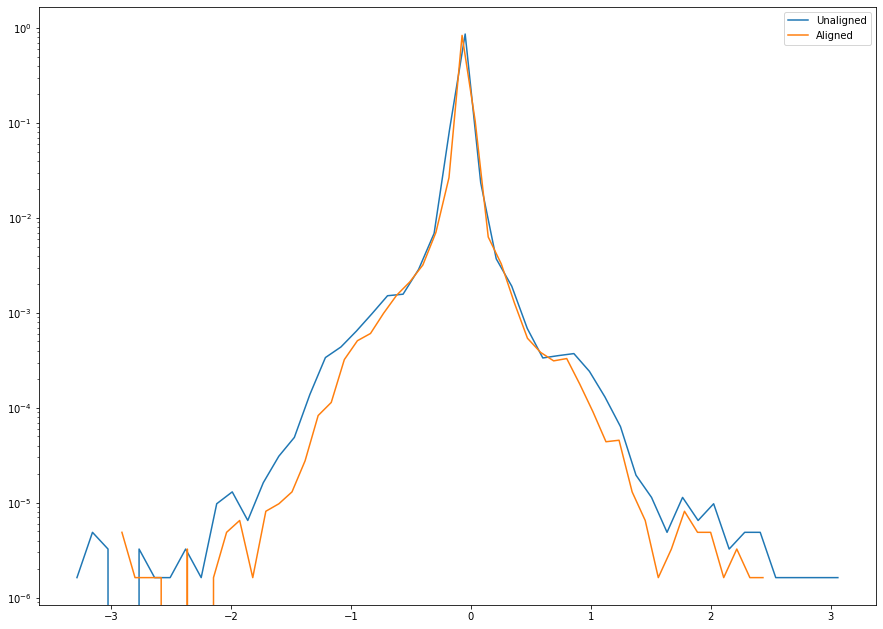

In [116]:
plot_gradients([rgb-fir, rgb_trans-fir], ["Unaligned", "Aligned"])

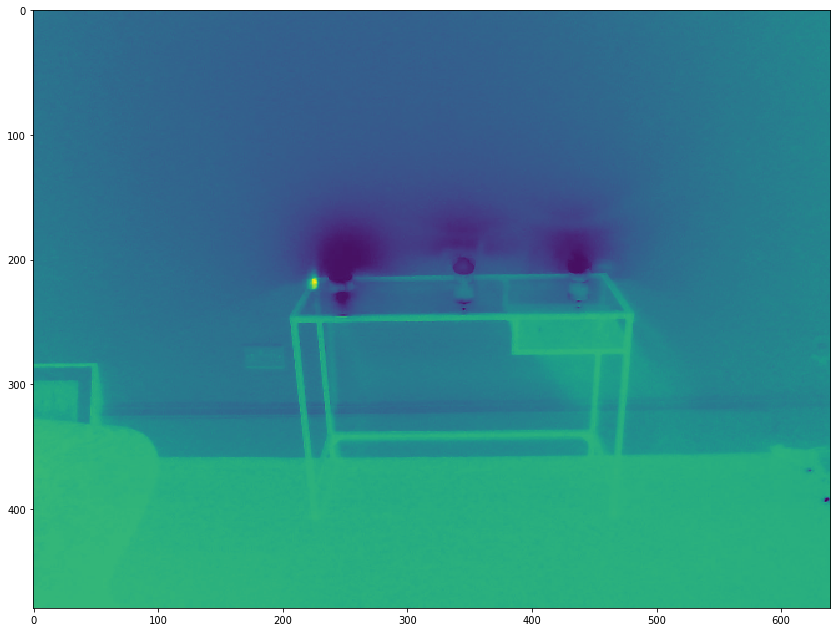

In [85]:
plt.imshow(fir-rgb)